# **Imports**

In [1]:
import zipfile, csv, os, io, string, pickle, math
import numpy as np
import matplotlib.pyplot as plt
import urllib.request as urllib
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

# **Constants**

In [43]:
GLOVE_URL = "http://nlp.stanford.edu/data/glove.6B.zip"
SENTENCES_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00331/sentiment%20labelled%20sentences.zip'

TEST_RATIO = 0.15
VALIDATION_RATIO = 0.1
MAX_DIM = 300
MAX_LENGTH = 50
NUM_OF_CLASSES = 2
LR = 0.001
LR_DECAY = 0.95
BETA1 = 0.9
BETA2 = 0.999
NUM_OF_EPOCHS = 8
BATCH_SIZE = 100
GAMMA = 0.9
SAVE_PATH_cost = '/content/gdrive/My Drive/cost_neuron_64.plk'
SAVE_PATH_Network = '/content/gdrive/My Drive/Net_neruon_64.plk'
SAVE_PATH_ACC_valid = '/content/gdrive/My Drive/acc_valid_neuron_64.plk'
SAVE_PATH_ACC_train = '/content/gdrive/My Drive/acc_train_neuron_64.plk'

# **GloVe Dictionary**

In [4]:
embedded_dict = {}
filehandle, _ = urllib.urlretrieve(GLOVE_URL)
zip_file_object = zipfile.ZipFile(filehandle, 'r')
print(zip_file_object.namelist())
f = zip_file_object.open('glove.6B.'+str(MAX_DIM)+'d.txt')
with io.TextIOWrapper(f) as file:
  for line in file:
      values = line.split()
      word = values[0]
      vectors = np.asarray(values[1:],"float32")
      embedded_dict[word] = vectors
file.close()

['glove.6B.50d.txt', 'glove.6B.100d.txt', 'glove.6B.200d.txt', 'glove.6B.300d.txt']


# **Reading dataset**

In [5]:
filehandle, _ = urllib.urlretrieve(SENTENCES_URL)
zip_file_object = zipfile.ZipFile(filehandle, 'r')
files = ['amazon_cells_labelled.txt', 'imdb_labelled.txt', 'yelp_labelled.txt']
fileName = [os.path.join('sentiment labelled sentences', f) for f in files]
labelledData = []
for i in range(len(fileName)):
  file = zip_file_object.open(fileName[i])
  with io.TextIOWrapper(file) as f:
    reader = csv.reader(f, delimiter='\t')
    for row in reader:
      row[0] = row[0].strip()
      labelledData.append((row[0],row[1]))
labelledData = np.array(labelledData)

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


# **Dataset Split**

In [7]:
np.random.shuffle(labelledData)
testSize = int(len(labelledData)*TEST_RATIO)
trainSize = int(len(labelledData)*(1-TEST_RATIO))
validSize = int(trainSize*VALIDATION_RATIO)
testData = labelledData[:testSize]
validData = labelledData[testSize : testSize+validSize]
trainData = labelledData[validSize+testSize:]
trainSet = trainData[:, 0]
validSet = validData[:, 0]
testSet = testData[:, 0]
trainLabel = trainData[:, 1]
validLabel = validData[:, 1]
testLabel = testData[:, 1]

# **Preparing Dataset**

In [8]:
def data_coding(data):
   punctuations = string.punctuation
   sentence = data.lower()
   new_sentence = ""
   for char in sentence:
     if char in punctuations:
       new_sentence += " " + char
     else:
       new_sentence += char
   sentence_arr = new_sentence.split()
   sentence_arr = sentence_arr[:min(len(sentence_arr), MAX_LENGTH)]
   dict_values = np.zeros((len(sentence_arr), MAX_DIM))
   sum_dict = np.zeros((MAX_DIM, 1))
   sum_sqr_dict = np.zeros((MAX_DIM, 1))
   for i, word in enumerate(sentence_arr):
     if word in embedded_dict:
       dict_val = embedded_dict[word]
       dict_values[i, :] = list(dict_val)
       dict_val = np.reshape(dict_val, (MAX_DIM, 1))
       sum_dict = np.add(sum_dict, dict_val)
       sum_sqr_dict = np.add(sum_sqr_dict, np.square(dict_val))
   sentence_code = dict_values
   return sentence_code, sum_dict, sum_sqr_dict, len(sentence_arr)

In [9]:
def calc_code_mean_std (data):
    X = data[:,0]
    Y = data[:,1]
    sum_dict = np.zeros((MAX_DIM, 1))
    sum_sqr_dict = np.zeros((MAX_DIM, 1))
    cnt = 0
    batch_code = []
    for i in range(len(X)):
      row_data, new_sum, new_sqr, new_len = data_coding(X[i])
      sum_dict = np.add(sum_dict, new_sum)
      sum_sqr_dict = np.add(sum_sqr_dict, new_sqr)
      cnt += new_len
      batch_code.append((row_data, int(Y[i])))
    mean_dict = np.divide(sum_dict, cnt)
    var_dict = np.subtract(np.divide(sum_sqr_dict, cnt), np.square(np.divide(sum_dict, cnt)))
    std_dict = np.sqrt(var_dict)
    return batch_code, mean_dict, std_dict
def calc_code_mean_std2 (data):
    X = data[:,0]
    Y = data[:,1]
    sum_dict = np.zeros((MAX_DIM, 1))
    sum_sqr_dict = np.zeros((MAX_DIM, 1))
    cnt = 0
    batch_code = []
    for i in range(len(X)):
      row_data, new_sum, new_sqr, new_len = data_coding(X[i])
      sum_dict = np.add(sum_dict, new_sum)
      sum_sqr_dict = np.add(sum_sqr_dict, new_sqr)
      cnt += MAX_LENGTH
      batch_code.append((row_data, int(Y[i])))
    mean_dict = np.divide(sum_dict, cnt)
    var_dict = np.subtract(np.divide(sum_sqr_dict, cnt), np.square(np.divide(sum_dict, cnt)))
    std_dict = np.sqrt(var_dict)
    return batch_code, mean_dict, std_dict
def calc_code_mean_std3 (data):
    X = data[:,0]
    Y = data[:,1]
    sum_dict = np.zeros((MAX_DIM, 1))
    sum_sqr_dict = np.zeros((MAX_DIM, 1))
    cnt = 0
    batch_code = []
    for i in range(len(X)):
      row_data, new_sum, new_sqr, new_len = data_coding2(X[i])
      sum_dict = np.add(sum_dict, new_sum)
      sum_sqr_dict = np.add(sum_sqr_dict, new_sqr)
      cnt += new_len
      batch_code.append((row_data, int(Y[i])))
    mean_dict = np.divide(sum_dict, cnt)
    var_dict = np.subtract(np.divide(sum_sqr_dict, cnt), np.square(np.divide(sum_dict, cnt)))
    std_dict = np.sqrt(var_dict)
    return batch_code, mean_dict, std_dict

In [10]:
def data_normalization(batch_code, mean, std):
    result = []
    for i in range(len(batch_code)):
      sentence_code = np.zeros((MAX_LENGTH, 1, MAX_DIM))
      
      sentence_code[:np.shape(batch_code[i][0])[0], 0, :] = np.divide(np.subtract(batch_code[i][0], np.transpose(mean)), np.transpose(std))
      
      result.append((sentence_code, batch_code[i][1]))

    return np.array(result)

def data_normalization2(batch_code, mean, std):
    result = []
    for i in range(len(batch_code)):
      sentence_code = np.zeros((MAX_LENGTH, 1, MAX_DIM))
      
      #sentence_code[:np.shape(batch_code[i][0])[0], 0, :] = np.divide(np.subtract(batch_code[i][0], np.transpose(mean)), np.transpose(std))
      
      sentence_code[:np.shape(batch_code[i][0])[0], 0, :] = batch_code[i][0]
      sentence_code = np.divide(np.subtract(sentence_code,np.transpose(mean)), np.transpose(std))
      result.append((sentence_code, batch_code[i][1]))

    return np.array(result)

# **Some Functions**

In [11]:
def function_builder(name, alpha=1, bias=0):
  def func(X):
    if name == 'Relu':
      X[X<=0] = 0
    elif name == 'LeakyRelu':
      X = np.max(alpha * X, X)
    elif name == 'ELU':
      X = alpha*(np.exp(X[X<=0])-1)
    elif name == 'Tanh':
      X = np.tanh(X)
    elif name == 'Linear':
      X = alpha*X + bias
    return X
  return func

In [12]:
def initializeFilter(size, scale = 1.0):
    stddev = scale/np.sqrt(np.prod(size))
    return np.random.normal(loc = 0, scale = stddev, size = size)

def initializeWeight(size):
    return np.random.standard_normal(size=size) * 0.01

def initializeParams ():
  m = [None]*len(Network)
  v = [None]*len(Network)
  mb = [None]*len(Network)
  vb = [None]*len(Network)

  for i, layer in enumerate(Network):
    if layer[0] == 'maxpool' or layer[0] == 'flatten':
      continue
    m[i] = np.zeros(layer[1].shape)
    v[i] = np.zeros(layer[1].shape)
    mb[i] = np.zeros(layer[2].shape)
    vb[i] = np.zeros(layer[2].shape)

  return [m, v, mb, vb]


In [13]:
def categoricalCrossEntropy(probs, label):
    return -np.sum(label * np.log(probs)) 

In [14]:
def nanargmax(arr):
    idx = np.nanargmax(arr)
    idxs = np.unravel_index(idx, arr.shape)
    return idxs

In [15]:
def calc_accuracy (data):
  X_test = data[:, 0]
  Y_true = data[:, 1]
  Y_pred = np.empty((np.shape(Y_true)))
  Y_probs = np.empty((np.shape(Y_true)))
  for i in range(len(data)):
    Y_pred[i], Y_probs[i] = predict(X_test[i])
  Y_pred = np.array(Y_pred).astype(int)
  return np.sum((Y_pred==Y_true).astype(int))/len(Y_true)*100, Y_pred

# **Layer Builders**

In [16]:
def convolution(data, weights, bias, stride):
    filter_x, filter_y, filter_depth, filter_num = np.shape(weights)
    data_x, data_y, data_depth = np.shape(data)
    result = np.zeros((data_x, data_y, filter_num))
    pad_size_x = filter_x // 2
    pad_size_y = filter_y // 2
    padded_data = np.pad(data, ((pad_size_x, pad_size_x), (pad_size_y, pad_size_y), (0, 0)), 'constant', constant_values=0)
    for n in range(filter_num):
        kernel_dy = pad_size_y
        result_y = 0
        while kernel_dy < data_y:
            kernel_dx = pad_size_x
            result_x  = 0
            while kernel_dx < data_x:
                result[result_x, result_y, n] = np.sum(np.multiply(weights[:, :, :, n], padded_data[kernel_dx:kernel_dx+filter_x, kernel_dy:kernel_dy+filter_y, :])) + bias[n]
                kernel_dx += stride
                result_x += 1
            kernel_dy += stride
            result_y += 1
    return result

In [17]:
def maxpool(data, pool_f): #pool_f is tuple (2, 1), pool_stride
    (data_x, data_y, data_depth) = np.shape(data)
    dim_x = math.ceil(data_x / pool_f[0])
    dim_y = math.ceil(data_y / pool_f[1])
    downsampled = np.zeros((dim_x, dim_y, data_depth))
    pad_size_x = pool_f[0] - data_x % pool_f[0]
    pad_size_y = pool_f[1] - data_y % pool_f[1]
    padded_data = np.pad(data, ((0, pad_size_x), (0, pad_size_y), (0, 0)), 'constant', constant_values=0)
    for i in range(data_depth):
        kernel_dy = 0
        result_y = 0
        while kernel_dy + pool_f[1] < np.shape(padded_data)[1]:
            kernel_dx   = 0
            result_x = 0
            while kernel_dx + pool_f[0] < np.shape(padded_data)[0]:
                downsampled[result_x, result_y, i] = np.max(padded_data[kernel_dx:kernel_dx+pool_f[0], kernel_dy:kernel_dy+pool_f[1], i])
                kernel_dx += pool_f[0]
                result_x += 1
            kernel_dy += pool_f[1]
            result_y += 1
    return downsampled

In [18]:
def convolutionBackward(dconv_prev, conv_in, filt, s):
   
    (f_dim_x, f_dim_y, f_depth, num_f) = filt.shape
    (orig_dim_x,orig_dim_y , _) = conv_in.shape
   
    dout = np.zeros(conv_in.shape) 
    dfilt = np.zeros(filt.shape)
    dbias = np.zeros((num_f,1))

    for curr_f in range(num_f):
      
        curr_y = out_y = 0
        while curr_y + f_dim_y <= orig_dim_y:
            curr_x = out_x = 0
            while curr_x + f_dim_x <= orig_dim_x:
                dfilt[: , : , : ,curr_f] += dconv_prev[out_x, out_y,curr_f] * conv_in[curr_x:curr_x + f_dim_x, curr_y:curr_y + f_dim_y,:]  ###########################         
                dout[curr_x:curr_x + f_dim_x, curr_y:curr_y + f_dim_y,:] += dconv_prev[out_x, out_y,curr_f] * filt[: , : , : ,curr_f] 
                curr_x += s
                out_x += 1
            curr_y += s
            out_y += 1
       
        dbias[curr_f] = np.sum(dconv_prev[: , : ,curr_f])
    
    return dout, dfilt, dbias

In [19]:
def maxpoolBackward(dpool, orig, pool_f):
   
    (orig_dim_x, orig_dim_y, orig_depth) = orig.shape
    
    dout = np.zeros(orig.shape)
    
    for curr_c in range(orig_depth):
        curr_y = out_y = 0
        while curr_y + pool_f[1] <= orig_dim_y:
            curr_x = out_x = 0
            while curr_x + pool_f[0] <= orig_dim_x:
                
                (a, b) = nanargmax(orig[curr_x:curr_x+ pool_f[0] , curr_y:curr_y + pool_f[1], curr_c])
                dout[ curr_x+a, curr_y+b, curr_c] = dpool[out_x, out_y, curr_c]
                
                curr_x += pool_f[0]
                out_x += 1
            curr_y += pool_f[1]
            out_y += 1
        
    return dout

In [20]:
def softmax(raw_preds):
    out = np.exp(raw_preds) 
    return out/np.sum(out) 

# **Design Network**

In [46]:
# conv, maxpool, fullyconn, flatten, softmax
Network = []
Network.append(['conv', initializeFilter((3, 1, MAX_DIM, 64)), np.zeros((64,1)), 'Relu'])
Network.append(['conv', initializeFilter((3, 1, 64, 64)), np.zeros((64,1)), 'Relu'])
Network.append(['maxpool', (2, 1)])

#Network.append(['conv', initializeFilter((3, 1, 128, 64)), np.zeros((64,1)), 'Relu'])
#Network.append(['conv', initializeFilter((3, 1, 64, 64)), np.zeros((64,1)), 'Relu'])
#Network.append(['maxpool', (2, 1)])

Network.append(['flatten',])
Network.append(['fullyconn', initializeWeight((64, 1600)), np.zeros((64,1)), 'Relu'])
Network.append(['fullyconn', initializeWeight((2,64)), np.zeros((2,1)), 'Softmax'])

In [22]:
data_dim_x = MAX_LENGTH
data_dim_y = 1
data_depth = MAX_DIM
f_dim1 = 3
f_dim2 = 1
num_filt1 = 64
num_filt2 = 64
num_neurons = 128
flatten_size = 1600

# **Implement Network**

In [23]:
def CNN_forward (data):
    results = [None]*(len(Network)+1)
    results[0] = data
    for i, layer in enumerate(Network):
      if (layer[0] == 'conv'):
        results[i+1] = convolution(results[i], layer[1], layer[2], 1)
        results[i+1] = function_builder(layer[3])(results[i+1])
      elif (layer[0] == 'maxpool'):
        results[i+1] = maxpool(results[i], layer[1])
      elif (layer[0] == 'flatten'):
        dim1, dim2, dim3 = np.shape(results[i])
        results[i+1] = results[i].reshape((dim1*dim2*dim3, 1))
      elif (layer[0] == 'fullyconn'):
        results[i+1] = layer[1].dot(results[i]) + layer[2]
        if layer[3] == 'Softmax':
          results[i+1] = softmax(results[i+1])
          break
        results[i+1] = function_builder(layer[3])(results[i+1])
    return results

In [24]:
def CNN_backward (results, label):
    dNetwork = [[None, None]]*len(Network)
    dresults = [None]*(len(Network)+1)
    dresults[-1] = results[-1] - label
    for i, layer in reversed(list(enumerate(Network))):
      if (layer[0] == 'conv'):
        dresults[i], df, db = convolutionBackward(dresults[i+1], results[i], layer[1], 1)
        dNetwork[i] = [df, db]
        if i != 0 and Network[i-1][0] == 'conv':
          dresults[i][results[i]<=0] = 0
      elif (layer[0] == 'maxpool'):
        dresults[i] = maxpoolBackward(dresults[i+1], results[i], layer[1])
        dresults[i][results[i]<=0] = 0
      elif (layer[0] == 'flatten'):
        dresults[i] = dresults[i+1].reshape(np.shape(results[i]))
      elif (layer[0] == 'fullyconn'):
        dw = dresults[i+1].dot(results[i].T)
        db = np.sum(dresults[i+1], axis=1).reshape(layer[2].shape)
        dNetwork[i] = [dw, db]
        dresults[i] = layer[1].T.dot(dresults[i+1])
        if Network[i-1][0] == 'flatten':
          continue
        dresults[i][results[i]<=0] = 0
    return dNetwork #, dresults[0]

In [25]:
def CNN (data, label):
    
    results = CNN_forward (data)
    dNetwork = CNN_backward(results, label)

    loss = categoricalCrossEntropy(results[-1], label)
    grads = dNetwork

    return grads, loss

# **Solver**

In [26]:
def momentumGD(dNetwork, lr, params):
    [m, v, mb, vb] = params
    for i, layer in enumerate(Network):

      if layer[0] == 'maxpool' or layer[0] == 'flatten':
        continue
      v[i] = GAMMA*v[i] + lr*(dNetwork[i][0]/BATCH_SIZE)
      layer[1] -= v[i]

      vb[i] = GAMMA*vb[i] + lr*(dNetwork[i][1]/BATCH_SIZE)
      layer[2] -= vb[i]

    return [m, v, mb, vb]

In [27]:
def adamGD (dNetwork, lr, params):
    [m, v, mb, vb] = params
    for i, layer in enumerate(Network):

      if layer[0] == 'maxpool' or layer[0] == 'flatten':
        continue
      m[i] = BETA1*m[i] + (1-BETA1)*dNetwork[i][0]/BATCH_SIZE 
      v[i] = BETA2*v[i] + (1-BETA2)*(dNetwork[i][0]/BATCH_SIZE)**2 
      m_hat = m[i]/(1-BETA1)
      v_hat = v[i]/(1-BETA2)
      layer[1] -= lr * m_hat/(np.sqrt(v_hat)+1e-7)

      mb[i] = BETA1*mb[i] + (1-BETA1)*dNetwork[i][1]/BATCH_SIZE
      vb[i] = BETA2*vb[i] + (1-BETA2)*(dNetwork[i][1]/BATCH_SIZE)**2
      mb_hat = mb[i]/(1-BETA1)
      vb_hat = vb[i]/(1-BETA2)
      layer[2] -= lr * mb_hat/(np.sqrt(vb_hat)+1e-7)

    return [m, v, mb, vb]

In [37]:
def solver(batch, lr, params, cost, optimizer):
    
    X = batch[:,0] 
    Y = batch[:,1] 
    cost_ = 0
    
    dNetwork = [[0, 0]]*len(Network)
    
    for i in range(len(X)):
        
        x = X[i]
        y = np.eye(NUM_OF_CLASSES)[int(Y[i])].reshape(NUM_OF_CLASSES, 1) 

        grads, loss = CNN(x, y)
        for j, grad in enumerate(grads):
          if grad[0] is None:
            continue
          if i == 0:
            dNetwork[j] = [np.zeros(grad[0].shape), np.zeros(grad[1].shape)]
          dNetwork[j][0] += grad[0]
          dNetwork[j][1] += grad[1]
        cost_+= loss/len(X)

    if optimizer == 'ADAM':
      new_params = adamGD(dNetwork, lr, params)
    elif optimizer == 'MOMENTUM':
      new_params = momentumGD(dNetwork, lr, params)

    #cost_ = cost_/BATCH_SIZE
    cost.append(cost_)

    return new_params, cost

# **Predictor**

In [29]:
def predict(data):
    results = CNN_forward(data)
    return np.argmax(results[-1]), np.max(results[-1])

In [47]:
params = initializeParams()

train_coded, mean_all, std_all = calc_code_mean_std2(trainData)
train_coded = data_normalization2(train_coded,mean_all,std_all)
valid_coded, _, _ = calc_code_mean_std2(validData)
valid_coded = data_normalization2(valid_coded, mean_all, std_all)

cost = []
accuracy_train = []
accuracy_valid = []

print("LR:"+str(LR)+", Batch Size:"+str(BATCH_SIZE))
for epoch in range(NUM_OF_EPOCHS):
    np.random.shuffle(trainData)
    batches = np.array([trainData[k:k + BATCH_SIZE] for k in range(0, trainData.shape[0], BATCH_SIZE)])
    t = tqdm(batches)
    for x,batch in enumerate(t):
        batch, mean_batch, std_batch = calc_code_mean_std2(batch)
        batch = data_normalization2(batch, mean_batch, std_batch)

        params, cost = solver(batch, LR*(LR_DECAY**x), params, cost, 'ADAM')
        t.set_description("Cost: %.6f" % (cost[-1]))    
    acc_train,_ = calc_accuracy(train_coded)
    accuracy_train.append(acc_train)
    acc_valid,_ = calc_accuracy(valid_coded)
    print(acc_valid)
    accuracy_valid.append(acc_valid)


with open(SAVE_PATH_cost, 'wb') as file:
    pickle.dump(cost, file)
with open(SAVE_PATH_Network, 'wb') as file:
    pickle.dump(Network, file)
with open(SAVE_PATH_ACC_valid,'wb') as file:
    pickle.dump(accuracy_valid,file)
with open(SAVE_PATH_ACC_train,'wb') as file:
    pickle.dump(accuracy_train,file)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


LR:0.001, Batch Size:100


Cost: 0.717913: 100%|██████████| 22/22 [10:22<00:00, 28.28s/it]


72.96137339055794


Cost: 0.174768: 100%|██████████| 22/22 [10:20<00:00, 28.23s/it]


75.53648068669528


Cost: 0.071974: 100%|██████████| 22/22 [10:19<00:00, 28.17s/it]


77.25321888412017


Cost: 0.722991: 100%|██████████| 22/22 [10:29<00:00, 28.61s/it]


80.68669527896995


Cost: 0.120475: 100%|██████████| 22/22 [10:33<00:00, 28.78s/it]


81.97424892703863


Cost: 0.428749: 100%|██████████| 22/22 [10:26<00:00, 28.49s/it]


83.2618025751073


Cost: 0.526849: 100%|██████████| 22/22 [10:25<00:00, 28.42s/it]


81.54506437768241


Cost: 0.012877: 100%|██████████| 22/22 [10:36<00:00, 28.93s/it]


83.2618025751073


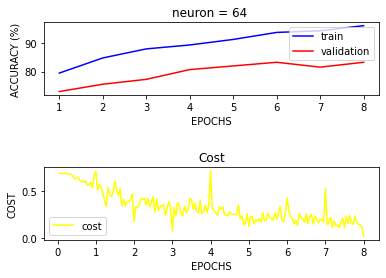

In [50]:
plt.subplot(2, 1, 1)
plt.title("neuron = 64 ")
plt.plot(range(1, len(accuracy_train)+1), accuracy_train, color='blue', label='train')
plt.plot(range(1, len(accuracy_valid)+1), accuracy_valid, color='red', label='validation')
plt.legend()
plt.xlabel("EPOCHS")
plt.ylabel("ACCURACY (%)")
plt.subplots_adjust(hspace=1)
plt.subplot(2, 1, 2)
plt.title('Cost')
plt.plot(range(1, len(cost)+1), cost, color='yellow', label='cost')
plt.legend()
plt.xticks(range(0, len(cost)+1, 22), list(range(9)))
plt.xlabel("EPOCHS")
plt.ylabel("COST")
plt.show()

# **Loading Parameters from Directory**

In [48]:
Network = pickle.load(open(SAVE_PATH_Network, 'rb'))

# **Testing**

In [49]:
test_coded, _, _ = calc_code_mean_std2(testData)
test_coded = data_normalization2(test_coded, mean_all, std_all)
acc,_ = calc_accuracy(test_coded)
print("Accuracy on test data for 64 neurons is "  + str(acc) + " %")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Accuracy on test data for 64 neurons is 85.19417475728154 %


Accuracy for zero padding is : 81.79611650485437%
